In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters


In [2]:
import pickle
with open('result/param_Fit_AM_fct_velocity_2_step_False_whitening.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

In [3]:
Fit = ANEMO.Fit(exp)
Plot = ANEMO.Plot(exp)

In [4]:
def regress(ax, p, data, x1, x2, y1, y2, t_label=20, color='r') :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=color, linewidth=2)
    ax.text(x2-(x2-x1)/10,y1+(y2-y1)/10, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')

    #hist, x_edges, y_edges = np.histogram2d(p, data ,bins=20)
    #ax.text(x2-(x2-x1)/10,y1+2*(y2-y1)/10, 'MI = %0.3f'%(mutual_information(hist)), color=color, fontsize=t_label/1.2, ha='right')

    return ax

In [5]:
def figure(N_trial, N_block=1,bruit=8, plot='') :

    nb_trial = N_trial*N_block
    
    x = np.arange(0,1500,1)
    TargetOn, StimulusOf = 750, 750-300
    np.random.seed(7)
    
    
    var_true, var_fit, var_old = {}, {}, {}
    for var in ['latency', 'a_anti', 'steady_state'] :
        var_true[var], var_fit[var], var_old[var] = [], [], []
    for var in ['start_anti', 'tau'] :
        var_true[var], var_fit[var] = [], []
        
        
    if plot!='scatter' :
        fig, axs = plt.subplots(nb_trial, 1, figsize=(10, nb_trial*(10*1/2)/1.6180))
        
    
    
    for block in range(N_block) :
        
        for trial in range(N_trial) :
            
            dir_target = exp['p'][trial][block][0]*2-1
            var_true['start_anti'].append(param['start_anti'][block][trial]+TargetOn)
            var_true['a_anti'].append(param['a_anti'][block][trial])
            var_true['latency'].append(param['latency'][block][trial]+TargetOn)
            var_true['tau'].append(param['tau'][block][trial])
            
            test = ANEMO.Equation.fct_velocity(x, dir_target, var_true['start_anti'][-1], var_true['a_anti'][-1],
                                               var_true['latency'][-1], var_true['tau'][-1], param['maxi'][block][trial],
                                               do_whitening=False)
            
            var_true['steady_state'].append((param['maxi'][block][trial]*dir_target + test[int(var_true['latency'][-1])])*dir_target)
            
            test = test + np.random.rand(len(x))*bruit
            test = test-np.random.rand(len(x))*bruit
            #saccades=[[770, 820, 50]]
            #test[770:820] =  np.arange(0,50,1)*np.nan

            old = {}
            old['latency'], old['maxi'], old['a_anti'] = ANEMO.classical_method.Full(test, TargetOn)

            f = Fit.Fit_trial(test, equation='fct_velocity', trackertime=None, TargetOn=TargetOn,
                              StimulusOf=StimulusOf, saccades=[], dir_target=dir_target,
                              value_latency=old['latency'], value_maxi=old['maxi'], value_anti=old['a_anti'],
                              before_sacc=5, after_sacc=15)

            fit = ANEMO.Equation.fct_velocity(np.arange(len(test)), dir_target,
                                              f.values['start_anti'], f.values['a_anti'],
                                              f.values['latency'], f.values['tau'],
                                              f.values['maxi'], do_whitening=False)

            steady_state = f.values['maxi']*dir_target + fit[int(f.values['latency'])]


            if plot=='scatter' :
                
                for var in ['latency', 'a_anti'] :
                    var_fit[var].append(f.values[var])
                    var_old[var].append(old[var])
                var_fit['steady_state'].append(steady_state*dir_target)
                var_old['steady_state'].append(old['maxi'])
                
                for var in ['start_anti', 'tau'] :
                    var_fit[var].append(f.values[var])

            else :
                
                if nb_trial==1 : ax = axs
                else : ax = axs[trial]
                    
                ax.plot(np.arange(-750,750), test, c='k', alpha=0.5)
                ax.plot(np.arange(-750,750), fit, c='k')

                
                ax.bar(f.values['latency']-TargetOn, 60, bottom=-30, color='k', width=4)
                ax.plot(np.arange(-750,750), np.ones(len(test))*steady_state, c='k')
                
                ax.bar(old['latency']-TargetOn, 60, bottom=-30, color='r', width=4)
                ax.plot(np.arange(-750,750), np.ones(len(test))*old['maxi']*(dir_target), c='r')
                
                ax.plot(np.arange(-50,50), range(100)*(old['a_anti']/1000), c='r', lw=2)
                ax = Plot.deco(ax, StimulusOn=0, StimulusOf=StimulusOf,
                               TargetOn=TargetOn, TargetOff=1400, t_label=10, saccades=[])
                ax.set_ylabel('Velocity (°/s)', fontsize=10)
                ax.set_title('block %s, trial %s'%(block, trial))
                
                #ax.plot(np.arange(-750,750), np.ones(len(test))*var_true['steady_state'][-1], c='g')
                
                plt.tight_layout() 
                
                
                
    if plot=='scatter' :
        fig, axs = plt.subplots(5, 2, figsize=(5*2, (5*5)/1.6180))
        for x, var in enumerate(['latency', 'a_anti', 'steady_state', 'start_anti', 'tau']) :
            axs[x][0].set_title('Fit %s'%var)
            axs[x][0].scatter(var_true[var], var_fit[var], c='k', alpha=0.5)
            axs[x][0] = regress(axs[x][0], var_true[var], var_fit[var],
                                x1=min(var_true[var]), x2=max(var_true[var]),
                                y1=min(var_fit[var]), y2=max(var_fit[var]))
            axs[x][0].set_xlabel('true')
            axs[x][0].set_ylabel('fit')
            
        for x, var in enumerate(['latency', 'a_anti', 'steady_state']) :
            axs[x][1].set_title('Old %s'%var)
            
            v_true = np.ma.masked_array(var_true[var], mask=np.isnan(var_old[var])).compressed()
            v_old = np.ma.masked_array(var_old[var], mask=np.isnan(var_old[var])).compressed()
            
            axs[x][1].scatter(v_true, v_old, c='k', alpha=0.5)
            axs[x][1] = regress(axs[x][1], v_true, v_old,
                                x1=min(v_true), x2=max(v_true),
                                y1=min(v_old), y2=max(v_old))
            axs[x][1].set_xlabel('true')
            axs[x][1].set_ylabel('old')    
            
        plt.tight_layout() 


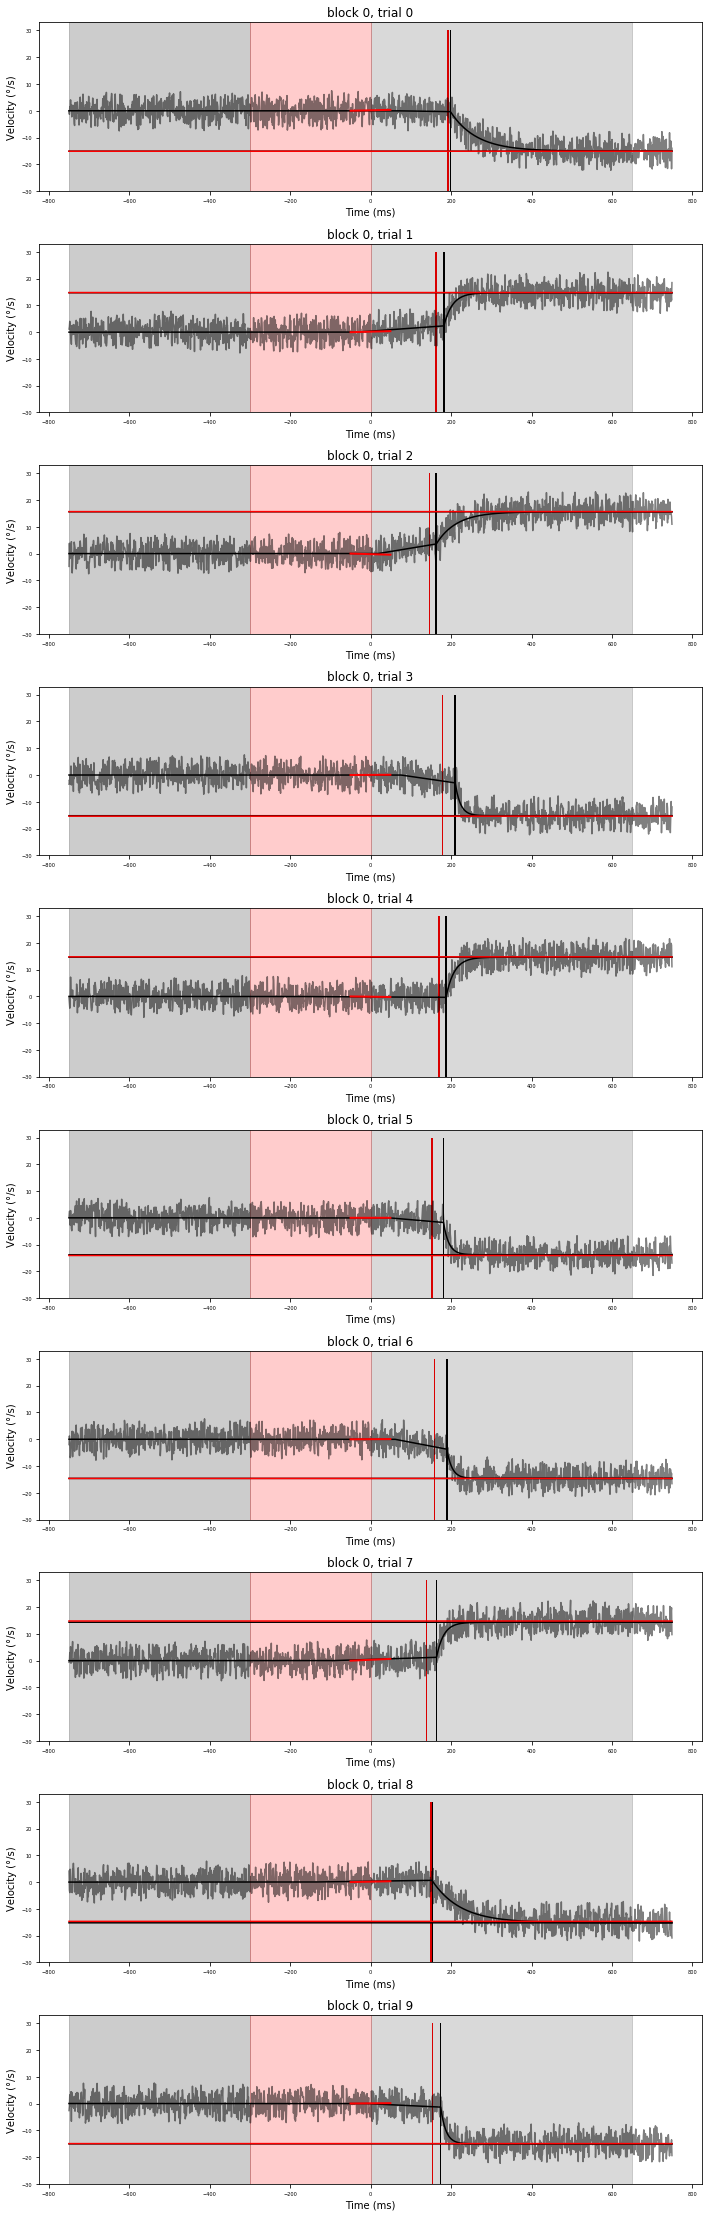

In [6]:
figure(N_trial=10)

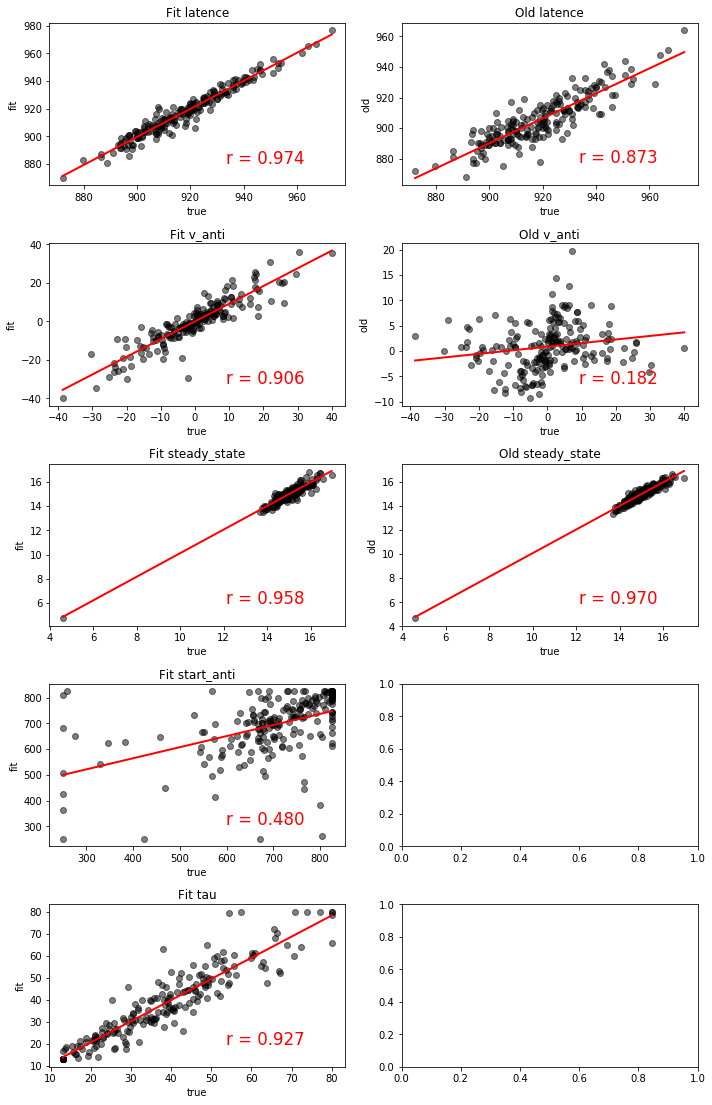

In [7]:
figure(N_trial=200, plot='scatter')